In [700]:
import numpy as np

class NeuralNetwork():
    def __init__(self, inputLayerSize, hiddenLayerSize, outputLayerSize):
        self.inputLayerSize = inputLayerSize 
        self.hiddenLayerSize = hiddenLayerSize 
        self.outputLayerSize = outputLayerSize 

        # Initialize Weights
        self.Wh = np.random.randn(inputLayerSize, hiddenLayerSize)/np.sqrt(inputLayerSize)
        self.Wo = np.random.randn(hiddenLayerSize, outputLayerSize)/np.sqrt(hiddenLayerSize)

        # Initialize Biases
        self.Bh = np.full((1, hiddenLayerSize), 0.1)
        self.Bo = np.full((1, outputLayerSize), 0.1)
        
    def normalize(self, arr, new_min, new_max):
        cur_min = np.min(arr)
        cur_max = np.max(arr)
        cur_range = (cur_max - cur_min)  
        new_range = (new_max - new_min)
        return (((arr - cur_min) * new_range) / cur_range) + new_min

    def denormalize(self, normalized, old_min, old_max):
        return self.normalize(normalized, old_min, old_max)
    
    def relu(self, Z):
        return np.maximum(0, Z)
    
    def relu_prime(self, Z):
        '''
        Z - weighted input matrix

        Returns the gradient of the 
        Z matrix where all negative 
        values are switched to 0 and
        all positive values switched to 1
        '''
        grad = np.copy(Z)
        grad[Z <= 0] = 0
        grad[Z > 0] = 1
        return grad
    
    def cost(self, output, y):
        cost = np.sum((output - y)**2) / 2.0
        return cost
    
    def cost_prime(self, output, y):
        return output - y

    def feed_forward(self, X):
        # Hidden layer
        Zh = np.dot(X, self.Wh) 
        H = self.relu(Zh + self.Bh)

        # Output layer
        Zo = np.dot(H, self.Wo)
        output = self.relu(Zo + self.Bo)
        return output
    
    def backprop(self, X, y, lr):
        '''
        X - input matrix from training set
        y - expected output matrix
        lr - learning rate
        '''
        ### Feed Forward ###
   
        # Hidden layer
        Zh = np.dot(X, self.Wh) 
        H = self.relu(Zh + self.Bh)

        # Output layer
        Zo = np.dot(H, self.Wo)
        out = self.relu(Zo + self.Bo)

        #### Backprop ####

        # Layer Error
        Eo = (out - y) * self.relu_prime(Zo + self.Bo)
        Eh = np.dot(Eo, self.Wo.T) * self.relu_prime(Zh + self.Bh)

        # Cost derivative for weights
        dWo = np.dot(H.T, Eo)
        dWh = np.dot(X.T, Eh)

        # Cost derivative for bias
        dBo = np.sum(Eo, axis=0, keepdims=True)
        dBh = np.sum(Eh, axis=0, keepdims=True)

        # Update weights
        self.Wo -= lr * dWo
        self.Wh -= lr * dWh

        # Update biases
        self.Bo -= lr * dBo
        self.Bh -= lr * dBh

    def extract_normalized_Xy_from_batch(self, batch):
        X = batch[:,0]
        y = batch[:,1]
        
        X = self.normalize(X, new_min=0, new_max=1)
        y = self.normalize(y, new_min=0, new_max=1)
        
        X.shape = (len(X),1)
        y.shape = (len(y),1)
        return X,y
        
    def SGD(self, data, batch_size, lr):
        N = len(data)
        np.random.shuffle(data)
        mini_batches = np.array(
            [data[i:i+batch_size] for i in range(0, N, batch_size)])
        for batch in mini_batches:
            X,y = self.extract_normalized_Xy_from_batch(batch)
            self.backprop(X, y, lr)

    def train(self, data, epochs, batch_size, lr):
        cost_history = []
        for epoch in range(epochs):
            self.SGD(data, batch_size, lr)
            
            # Store cost for auditing purposes
            X,y = self.extract_normalized_Xy_from_batch(data)
            output = self.feed_forward(X)
            cost = self.cost(output, y)
            cost_history.append(cost)
            
            # Log cost
            if epoch % 5000 == 0:
                print("Epoch " + str(epoch) + " Cost:" + str(round(cost,5)))
        print("Final cost " + str(round(cost,5)))
        return cost_history
    
    def predict(self, X, y_min, y_max):
        X = self.normalize(X, new_min=0, new_max=1)
        X.shape = (len(X),1)
        output = self.feed_forward(X)
        denormalized_output = self.denormalize(output, y_min, y_max)
        return denormalized_output

### Visualize

In [701]:
import matplotlib.pyplot as plt

def graph(x, y, xlabel="X", ylabel="Y", title="X vs Y"):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def graph_error(error_history):
    iterations = [i for i in range(1,len(error_history)+1)]
    plt.plot(iterations, error_history)
    plt.title('Error Rate')
    plt.xlabel('Training Iterations')
    plt.ylabel('Mean Squared Error')
    plt.show()

### Load Data

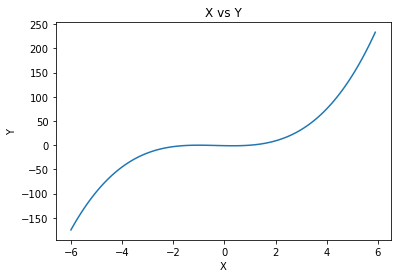

[[  -6.    -175.   ]
 [  -5.9   -165.669]
 [  -5.8   -156.672]]


In [702]:
def cubic(x):
    return x**3 + x**2 - x - 1

def get_cubic_data(start,end,step_size=1):
    data = np.array([ [i,cubic(i)] for i in np.arange(start,end,step_size)], dtype="float64")    
    return data

data = get_cubic_data(-6,6,.1)
X = data[:,0]
y = data[:,1]
graph(X,y)
print (data[:3])

### Train

In [703]:
data = get_cubic_data(-20,20)
print (len(data))
nn = NeuralNetwork(1,20,1)
print(nn.Wh)

40
[[-0.09839296  0.64534941 -0.8570218   0.55462981 -0.1056885   0.3366165
   2.4885778   0.56716701  0.75459265 -0.25900206 -0.51433369 -0.54086663
   0.18949197  1.8899767  -2.1706261  -1.40179121 -0.15135098  0.55893739
   1.29024007  0.71530896]]


Epoch 0 Cost:5.34141
Epoch 5000 Cost:0.09184
Epoch 10000 Cost:0.08828
Epoch 15000 Cost:0.08583
Epoch 20000 Cost:0.08395
Epoch 25000 Cost:0.08253
Epoch 30000 Cost:0.08138
Epoch 35000 Cost:0.08033
Epoch 40000 Cost:0.07939
Epoch 45000 Cost:0.07848
Epoch 50000 Cost:0.07758
Epoch 55000 Cost:0.07668
Epoch 60000 Cost:0.07578
Epoch 65000 Cost:0.07486
Epoch 70000 Cost:0.07391
Epoch 75000 Cost:0.07292
Epoch 80000 Cost:0.0719
Epoch 85000 Cost:0.07083
Epoch 90000 Cost:0.06971
Epoch 95000 Cost:0.06854
Epoch 100000 Cost:0.06732
Epoch 105000 Cost:0.06605
Epoch 110000 Cost:0.06472
Epoch 115000 Cost:0.06334
Epoch 120000 Cost:0.06191
Epoch 125000 Cost:0.06043
Epoch 130000 Cost:0.05891
Epoch 135000 Cost:0.05735
Epoch 140000 Cost:0.05576
Epoch 145000 Cost:0.05415
Epoch 150000 Cost:0.05252
Epoch 155000 Cost:0.05088
Epoch 160000 Cost:0.04923
Epoch 165000 Cost:0.04758
Epoch 170000 Cost:0.04594
Epoch 175000 Cost:0.04431
Epoch 180000 Cost:0.0427
Epoch 185000 Cost:0.04111
Epoch 190000 Cost:0.03954
Epoch 195000 

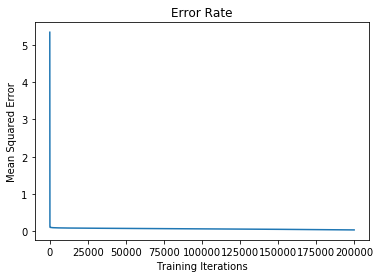

In [704]:
cost_hist = nn.train(data, epochs=200000, batch_size=40, lr=.0001)
graph_error(cost_hist)

### Predict

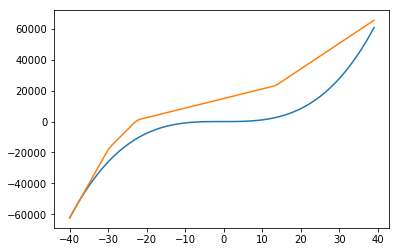

In [705]:
start,end = (-40,40)
data = get_cubic_data(start, end)
X,y = data[:,0],data[:,1]
predictions = nn.predict(X, y_min=cubic(start), y_max=cubic(end))
plt.plot(X, y)
plt.plot(X, predictions)

plt.show()